# Importing required libraries

In [2]:
# importing libraries
import pandas as pd
import seaborn as sns
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics

# Reading data

In [3]:
data=pd.read_csv('adult.data',header=None)
data.columns=['age','workclass','fnlwgt','education','education-num',
              'marital-status','occupation','relationship','race','sex',
            'capital-gain', 'capital-loss','hours-per-week','native-country','class']

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

In [5]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Initial quality checks on data

In [6]:
# checking for nulls
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
class             0
dtype: int64

In [7]:
# validating dtypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  class           32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [8]:
# we is some class imbalance
pd.DataFrame(data['class'].value_counts(normalize=True))

,class
<=50K,0.75919
>50K,0.24081


In [9]:
# validatig values in categorical data to check for text-errors
for c in data.select_dtypes('object').columns.to_list():
    print(data[c].unique())

[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']
[' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']
[' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']
[' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' ?'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv']
[' Not-in-family' ' Husband' ' Wife' ' Own-child' ' Unmarried'
 ' Other-relative']
[' White' ' Black' ' Asian-Pac-Islander' ' Amer-Indian-Eskimo' ' Other']
[' Male' ' Female']
[' United-States' ' Cuba' ' Jamaica' ' India' ' ?' ' Mexico' ' South'
 ' Puerto-Rico' ' Honduras' ' England' ' Canada' ' Germany' 

In [10]:
# we see additonal spaces in categorical values, applying strip function to remove it
for c in data.select_dtypes('object').columns.to_list():
    data[c]=data[c].apply(lambda x:x.strip())
    print(data[c].unique())
    

['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked']
['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']
['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']
['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' '?'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv']
['Not-in-family' 'Husband' 'Wife' 'Own-child' 'Unmarried' 'Other-relative']
['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']
['Male' 'Female']
['United-States' 'Cuba' 'Jamaica' 'India' '?' 'Mexico' 'South'
 'Puerto-Rico' 'Honduras' 'England' 'Canada' 'Germany' 'Iran'
 'Philippines' 'Italy' 'Poland' 'Columbia' 'Cambodia' 'Thailand' '

In [11]:
# checking value counts in categorical features
for c in data.select_dtypes('object').columns.to_list():
    print(data[c].value_counts(normalize=True))

Private             0.697030
Self-emp-not-inc    0.078038
Local-gov           0.064279
?                   0.056386
State-gov           0.039864
Self-emp-inc        0.034274
Federal-gov         0.029483
Without-pay         0.000430
Never-worked        0.000215
Name: workclass, dtype: float64
HS-grad         0.322502
Some-college    0.223918
Bachelors       0.164461
Masters         0.052916
Assoc-voc       0.042443
11th            0.036086
Assoc-acdm      0.032769
10th            0.028654
7th-8th         0.019840
Prof-school     0.017690
9th             0.015786
12th            0.013298
Doctorate       0.012684
5th-6th         0.010227
1st-4th         0.005160
Preschool       0.001566
Name: education, dtype: float64
Married-civ-spouse       0.459937
Never-married            0.328092
Divorced                 0.136452
Separated                0.031479
Widowed                  0.030497
Married-spouse-absent    0.012837
Married-AF-spouse        0.000706
Name: marital-status, dtype: float64


In [12]:
# we see '?' charcater, replacing it with 'other'
data=data.replace('?', 'other')
for c in data.select_dtypes('object').columns.to_list():
    print(data[c].value_counts(normalize=True))

Private             0.697030
Self-emp-not-inc    0.078038
Local-gov           0.064279
other               0.056386
State-gov           0.039864
Self-emp-inc        0.034274
Federal-gov         0.029483
Without-pay         0.000430
Never-worked        0.000215
Name: workclass, dtype: float64
HS-grad         0.322502
Some-college    0.223918
Bachelors       0.164461
Masters         0.052916
Assoc-voc       0.042443
11th            0.036086
Assoc-acdm      0.032769
10th            0.028654
7th-8th         0.019840
Prof-school     0.017690
9th             0.015786
12th            0.013298
Doctorate       0.012684
5th-6th         0.010227
1st-4th         0.005160
Preschool       0.001566
Name: education, dtype: float64
Married-civ-spouse       0.459937
Never-married            0.328092
Divorced                 0.136452
Separated                0.031479
Widowed                  0.030497
Married-spouse-absent    0.012837
Married-AF-spouse        0.000706
Name: marital-status, dtype: float64


# Exploring numerical features

In [13]:
data.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [14]:
# we see a right-skewed distribution in some features(capital-gain	capital-loss),this maybe due to some outliers. 
# Since 25th and 75th percentile is 0 for these features, we can't use IQR, so using standard-deviation(z-score) 
# to remove outliers.
for c in data.select_dtypes('int64').columns.to_list():
    data_mean, data_std = np.mean(data[c]), np.std(data[c])
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    data = data[(data[c]>lower) & (data[c]<upper)]
    
# checking stats after outlier removal
data.describe()


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,29829.000000,29829.000000,29829.000000,29829.000000,29829.000000,29829.000000
mean,38.143384,185203.291093,10.077978,570.198096,1.209326,39.896108
std,13.357377,94563.592391,2.452818,2332.499433,32.711007,11.139308
min,17.000000,12285.000000,3.000000,0.000000,0.000000,4.000000
25%,27.000000,117509.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,177669.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,234286.000000,12.000000,0.000000,0.000000,45.000000
max,79.000000,506436.000000,16.000000,22040.000000,1258.000000,77.000000


In [15]:
# cheking amount of data reduced after outlier removal

print("Before outier removal ",32561)
print("After outier removal ",29829)
print("Percentage change after outier removal ",29829/32561*100)


Before outier removal  32561
After outier removal  29829
Percentage change after outier removal  91.60959429992937


we see 9% reduction after removal of outliers

# Numerical EDA

Pair plots

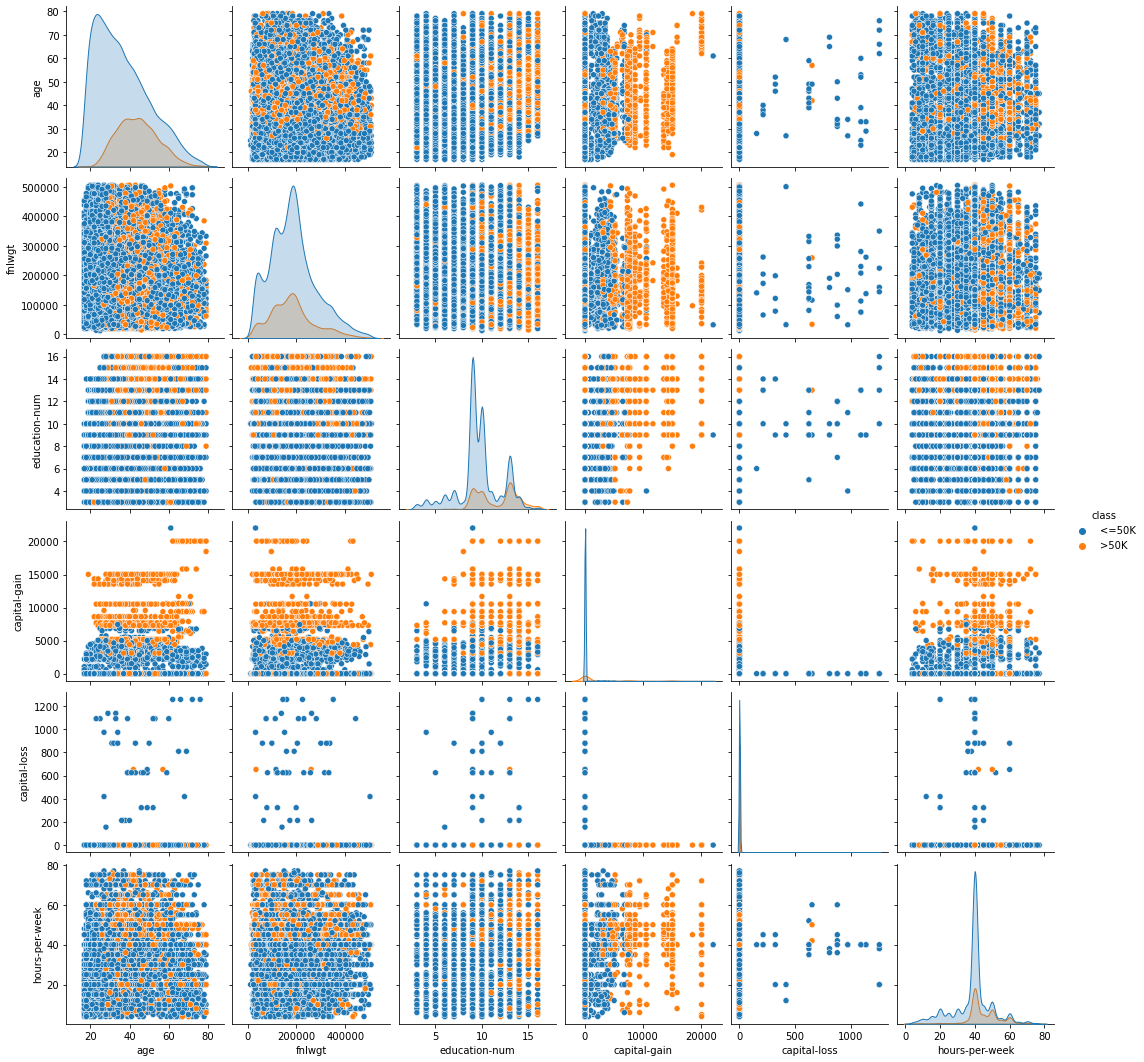

In [16]:
sns.pairplot(data,hue='class')

Correlation heatmap

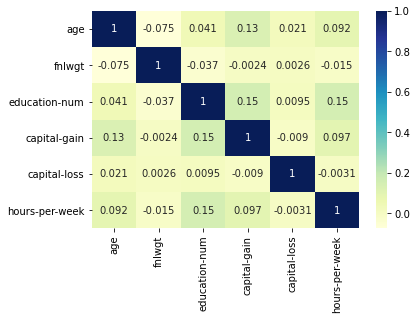

In [17]:
dataplot = sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [18]:

def numerical_plots_count(df,feature):
    fig, ax = plt.subplots()

    ax.hist(df[df["class"]=='<=50K'][feature], bins=15, alpha=0.5, color="blue", label="Less than 50k")
    ax.hist(df[df["class"]=='>50K'][feature], bins=15, alpha=0.5, color="green", label="More than 50k")

    ax.set_xlabel(feature)
    ax.set_ylabel("Count of people")

    fig.suptitle("{} vs. Salary".format(feature))

    ax.legend();
    
def numerical_plots_kde(df,feature):
    fig, ax = plt.subplots()

    sns.kdeplot(df[df["class"]=='<=50K'][feature], shade=True, color="blue",  label="Less than 50k", ax=ax)
    sns.kdeplot(df[df["class"]=='>50K'][feature], shade=True, color="green", label="More than 50k", ax=ax)

    ax.set_xlabel(feature)
    ax.set_ylabel("Density")

    fig.suptitle("{} vs. Salary".format(feature))
    ax.legend();

def box_plots(df,feature):
    fig, ax = plt.subplots()

    sns.boxplot(x="class", y=feature, data=df, ax=ax)

    ax.get_yaxis().set_visible(True)

    fig.suptitle("{} vs. Salary".format(feature))


Count plots

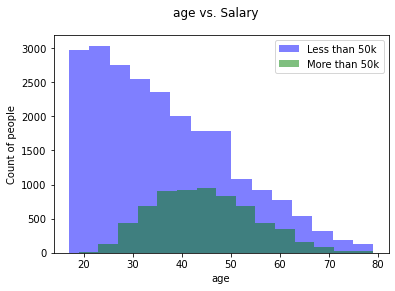

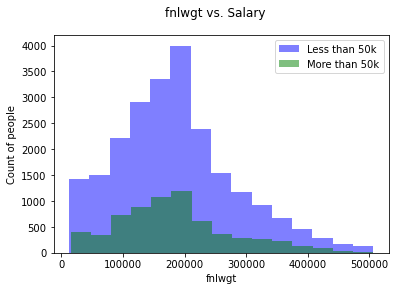

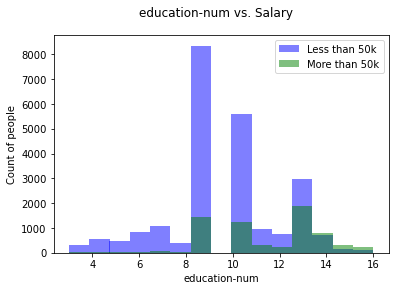

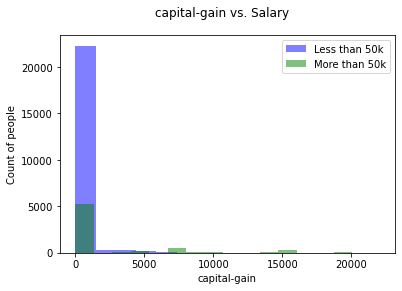

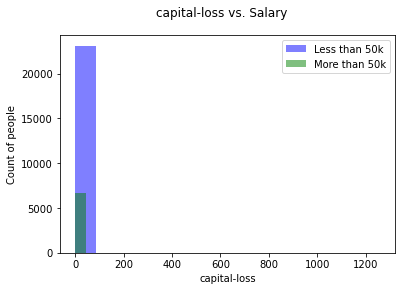

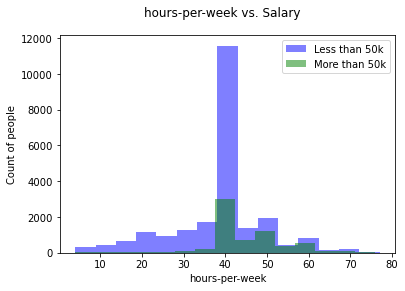

In [19]:
for c in data.select_dtypes('int64').columns.to_list():
    numerical_plots_count(data,c)

KDE plots

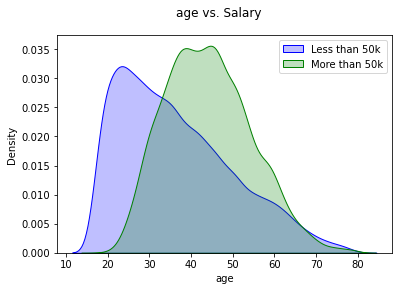

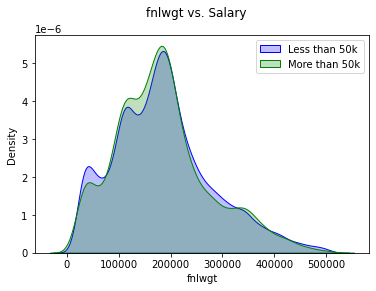

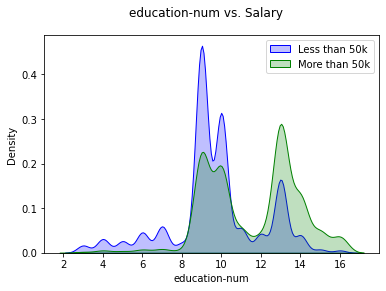

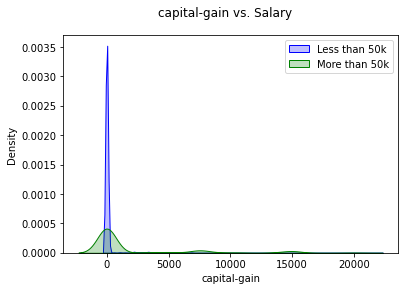

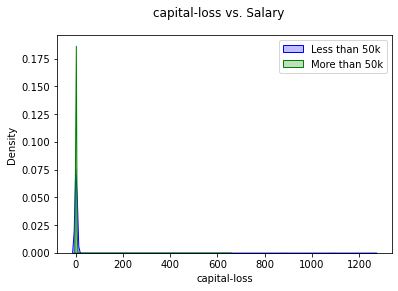

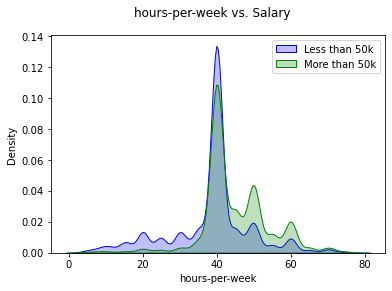

In [20]:
for c in data.select_dtypes('int64').columns.to_list():
    numerical_plots_kde(data,c)

Box plots

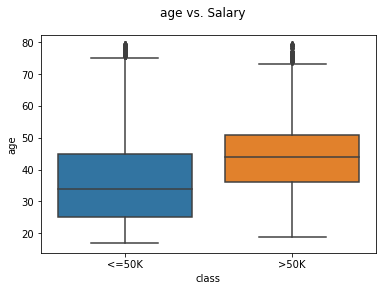

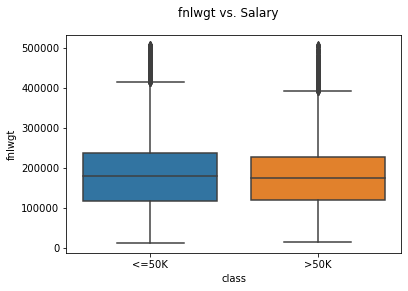

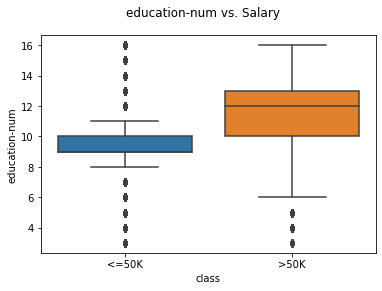

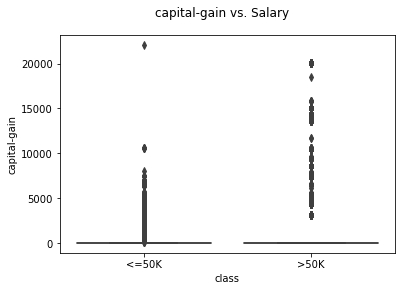

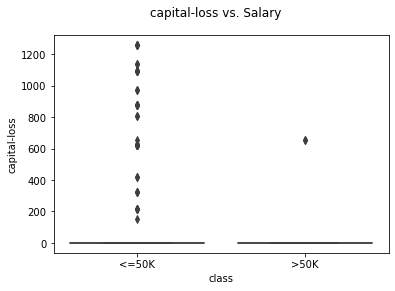

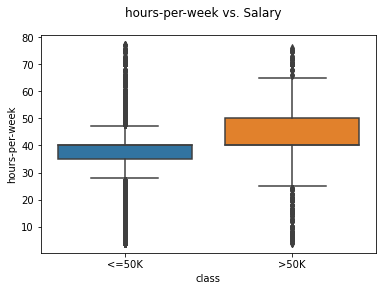

In [21]:
for c in data.select_dtypes('int64').columns.to_list():
    box_plots(data,c)

Observations based on numerical EDA:
1. There is not much inter-correlation among the numerical features.
2. People having less than 35 years of age are generally getting less than 50k salary.
3. People having less than 10 as education_num are generally getting less than 50k salary.
4. Hihgher captial gain points to a higher salary whereas higher capital loss points to a lower salary.
5. People putting less than 40 hours per week generally get a lower salary of <50k.

# Exploring categorical features

In [22]:
# checking distribution of target class for different values in categorical features
for c in data.select_dtypes('object').columns.to_list():
    print('For feature ',c)
    print('Value counts by feature')
    print(data[c].value_counts(normalize=True))
    print('\n')
    print('Value counts by feature-class')
    print(data.groupby([c])['class'].value_counts(normalize=True))
    print('***********')

For feature  workclass
Value counts by feature
Private             0.703544
Self-emp-not-inc    0.074190
Local-gov           0.064199
other               0.055449
State-gov           0.040799
Self-emp-inc        0.031446
Federal-gov         0.029669
Without-pay         0.000469
Never-worked        0.000235
Name: workclass, dtype: float64


Value counts by feature-class
workclass         class
Federal-gov       <=50K    0.620339
                  >50K     0.379661
Local-gov         <=50K    0.718538
                  >50K     0.281462
Never-worked      <=50K    1.000000
Private           <=50K    0.797293
                  >50K     0.202707
Self-emp-inc      >50K     0.518124
                  <=50K    0.481876
Self-emp-not-inc  <=50K    0.739720
                  >50K     0.260280
State-gov         <=50K    0.746919
                  >50K     0.253081
Without-pay       <=50K    1.000000
other             <=50K    0.906288
                  >50K     0.093712
Name: class, dtype: float64


In [23]:
def stack_plot(data,feature):
    fig, ax = plt.subplots(figsize=[20,4])
    sns.histplot(binwidth=0.5, x=feature, hue="class", data=data, stat="count", multiple="stack",ax=ax)
    ax.set_xlabel(feature)
    ax.set_ylabel("Count")

    fig.suptitle("{} vs. Salary".format(feature))

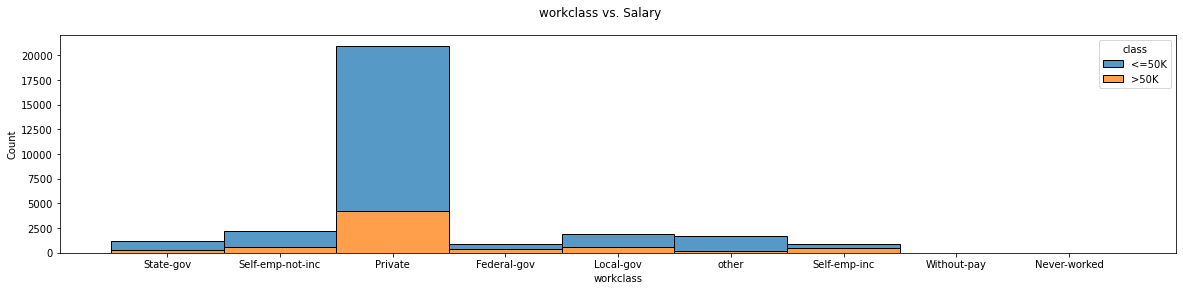

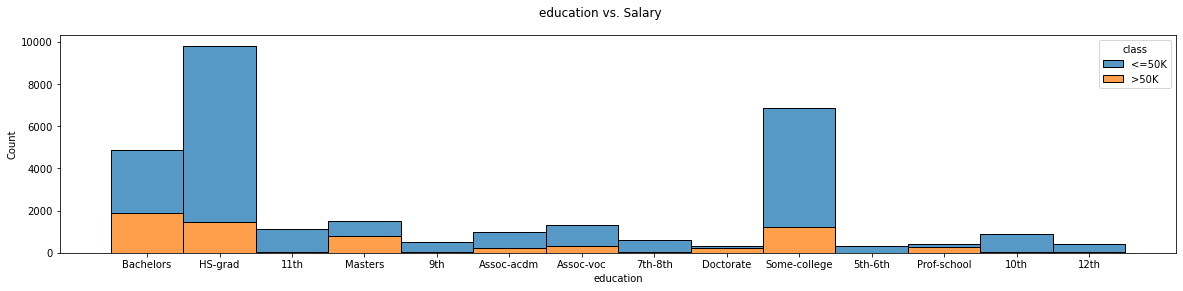

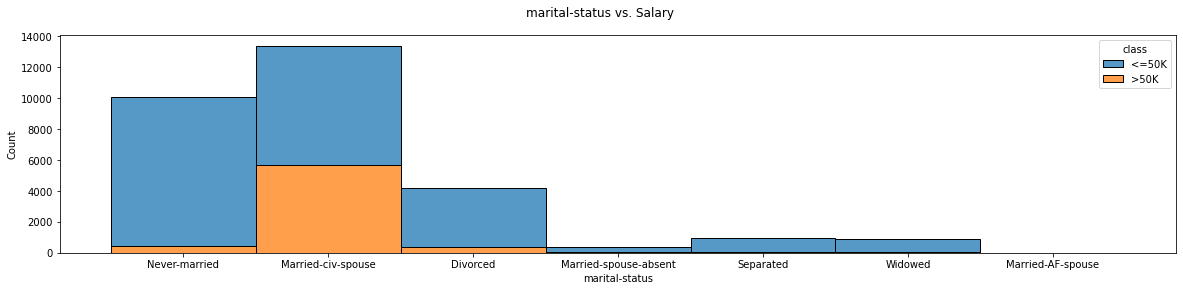

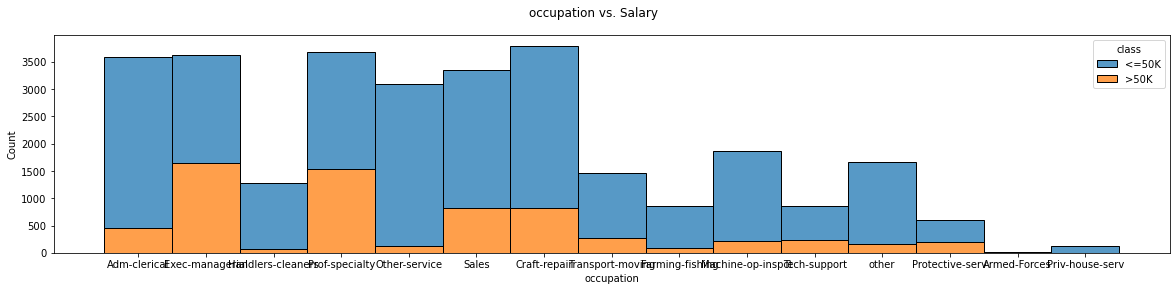

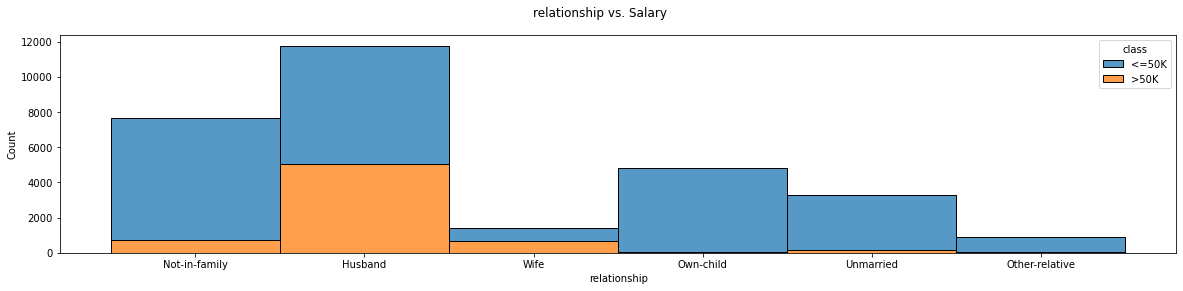

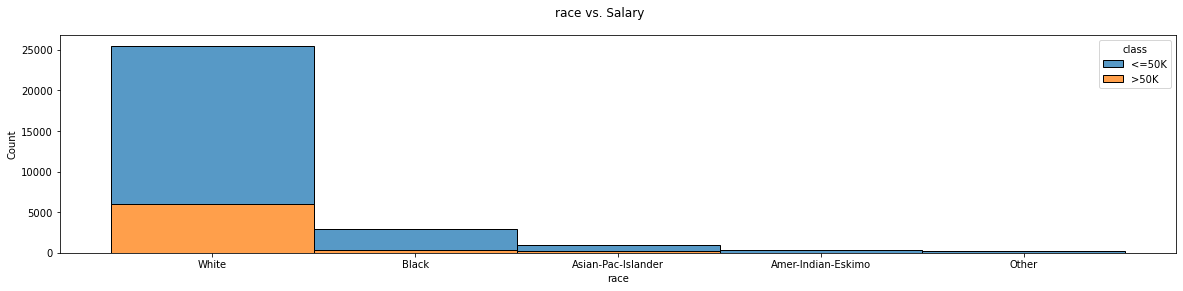

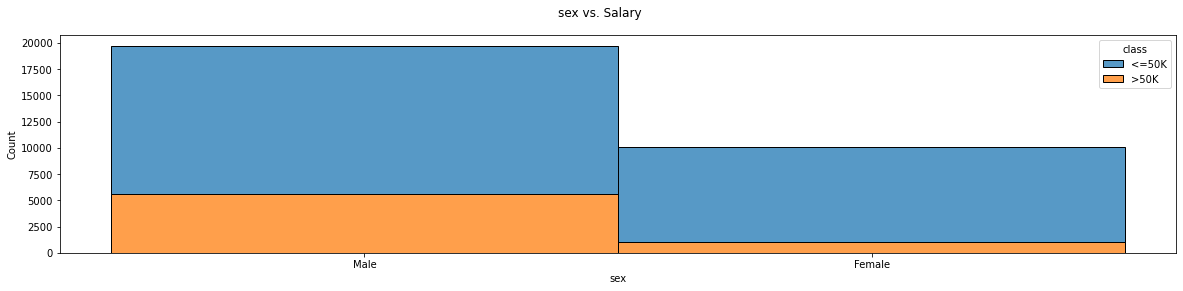

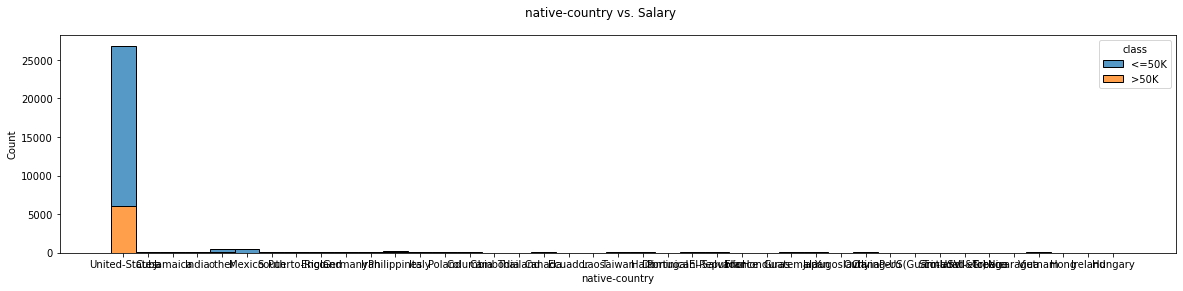

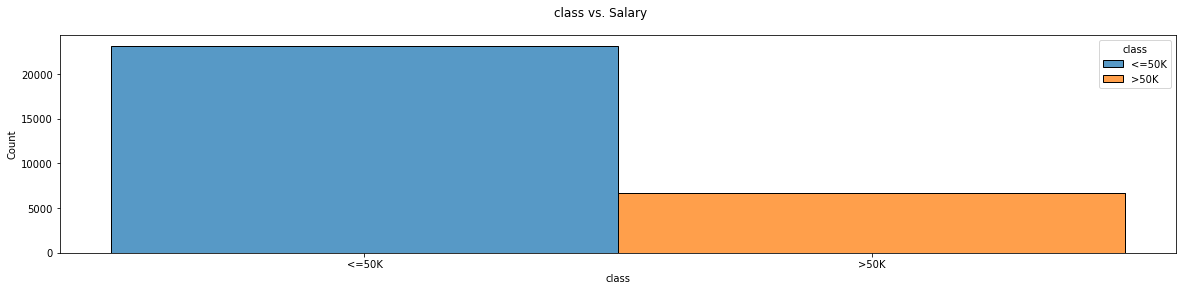

In [24]:
for c in data.select_dtypes('object').columns.to_list():
      stack_plot(data,c)

In [25]:
# Based on categorical EDA results we combine few values in categorical features
val_dict={
    'workclass':{'State-gov':'Gov','Federal-gov':'Gov','Local-gov':'Gov','Without-pay':'other',
                 'Never-worked':'other'},
    'education':{'11th':'School','9th':'School','7th-8th':'School',
                 '5th-6th':'School','10th':'School','12th':'School',
                'assoc-acdm':'assoc','assoc-voc':'assoc'},
    
    'marital-status':{'Separated':'married_single','Widowed':'married_single','Married-spouse-absent':'married_single'},
    'relationship':{'Other-relative':'others','Own-child':'others'},
    'race':{'Amer-Indian-Eskimo':'others','Other':'others'}
}
def combine_categories(c,x):
    if c in val_dict:
        if x in val_dict[c]:
            return val_dict[c][x]
    return x

Combining the values in categories

In [26]:
for c in data.select_dtypes('object').columns.to_list():
    data[c]=data[c].apply(lambda x: combine_categories(c,x))

Plotting charts for new values

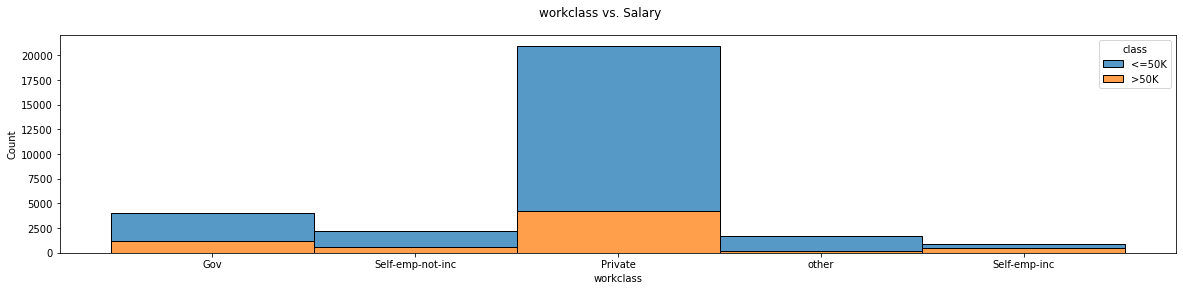

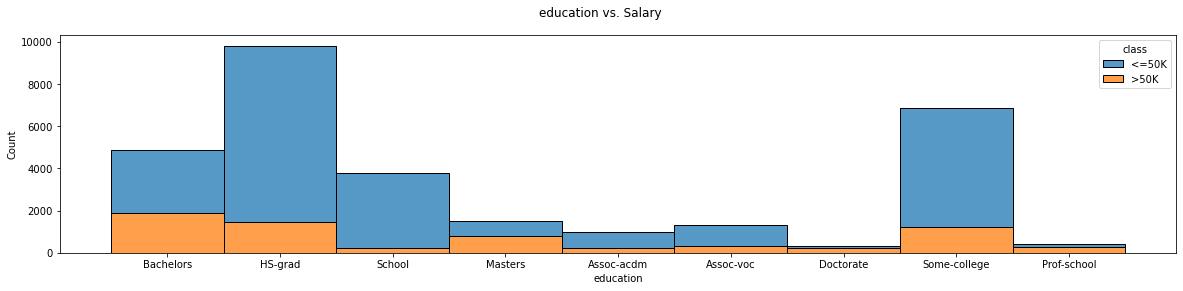

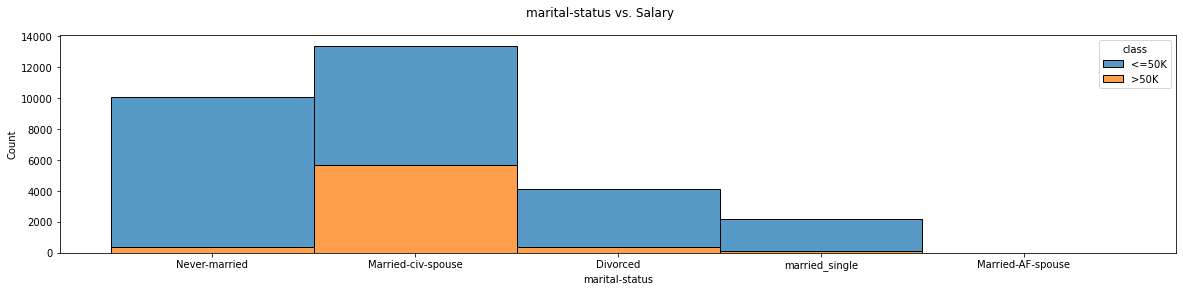

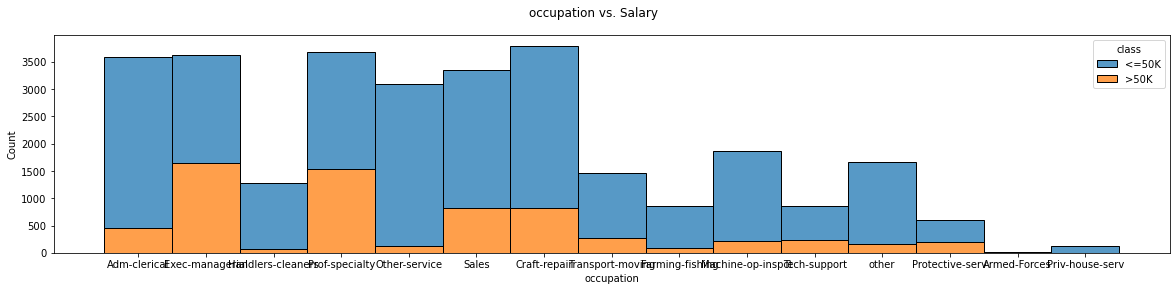

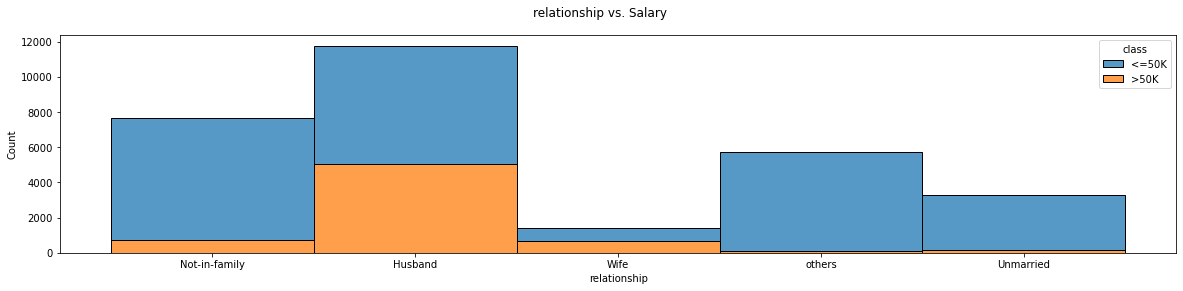

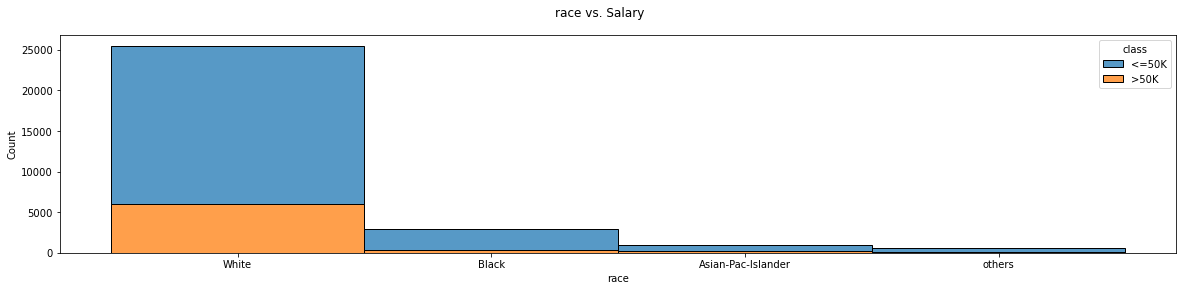

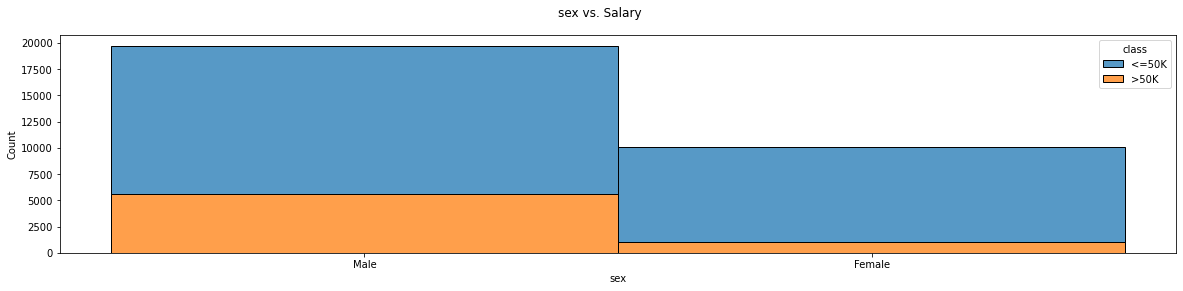

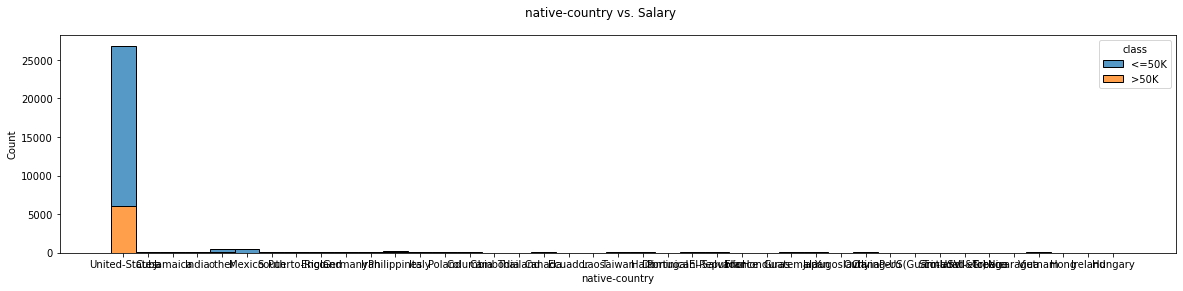

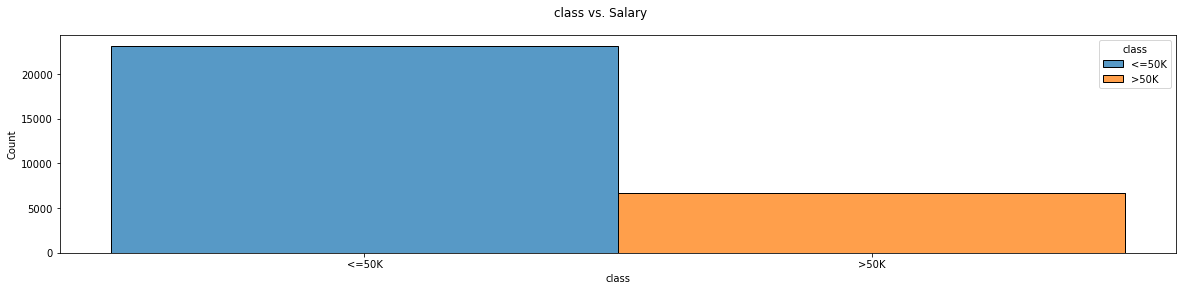

In [27]:
for c in data.select_dtypes('object').columns.to_list():
      stack_plot(data,c)

Observations based on numerical EDA:
1. People studied only till school generally get <50k salary whereas people with Doctorate generally get >50k.
3. People having race as others m are generally getting less than 50k salary.
4. There is less propotion of female popultaion having >50k salary as compared to males.

# Model Building

Since we have a lot of categorical features as input and some outliers, its better to use a tree based algorithm.

In [28]:
# updating target variable
data['salary>50k']=np.where(data['class']=='>50K',1,0)

In [29]:
categorical_feature=['workclass', 'education', 'marital-status', 'occupation',
                                          'relationship', 'race', 'sex', 'native-country']
for c in categorical_feature:
    data[c]=data[c].astype('category')

In [30]:
Y=data['salary>50k']
X=data.drop(columns=['salary>50k','class'],axis=1)

In [31]:
#train_test_split 
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=0)

In [32]:
#converting the dataset into proper LGB format 
lgtrain=lgb.Dataset(X_train, label=y_train)
lgvalid = lgb.Dataset(X_test, y_test)

In [34]:
#Specifying the basic parameters
params = {
    'objective' : 'binary',
    'metric' : 'auc',
    'verbosity' : -1,
    'boosting_type':'gbdt' ,
    'is_unbalance':True,
    'early_stopping_rounds':20
    
}

#train the model on basic params
clf=lgb.train(params,lgtrain,valid_sets=[lgtrain,lgvalid],verbose_eval=10)

F:\Anaconda_new\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
F:\Anaconda_new\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
F:\Anaconda_new\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 20 rounds
[10]	training's auc: 0.917882	valid_1's auc: 0.905886
[20]	training's auc: 0.922947	valid_1's auc: 0.909604
[30]	training's auc: 0.927174	valid_1's auc: 0.911319
[40]	training's auc: 0.931622	valid_1's auc: 0.913478
[50]	training's auc: 0.93556	valid_1's auc: 0.915985
[60]	training's auc: 0.938295	valid_1's auc: 0.917106
[70]	training's auc: 0.940875	valid_1's auc: 0.917224
[80]	training's auc: 0.94308	valid_1's auc: 0.917178
[90]	training's auc: 0.94528	valid_1's auc: 0.916878
Early stopping, best iteration is:
[72]	training's auc: 0.941263	valid_1's auc: 0.917299


# Hyperparameter tuning

Using grid search to find best parameters

In [35]:

clf = LGBMClassifier()
params = {
    # basic params
        'objective' : ['binary'],
        'metric' : ['auc'],
        'verbosity' : [-1],
        'boosting_type':['gbdt'] ,
        'is_unbalance':[True],
#         'early_stopping_rounds':[20],
    # search params
        'num_leaves' :[10,20,30],
        'learning_rate':[0.01,0.03,0.05],
        'feature_fraction': [0.6, 0.8, 1.0],
        'max_depth': [3,5,8,10]
        }
grid = GridSearchCV(estimator=clf, param_grid=params, cv = 3, n_jobs=-1,verbose=2.5)


grid = grid.fit(X_train, y_train)
# # Summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best: 0.852994 using {'boosting_type': 'gbdt', 'feature_fraction': 0.6, 'is_unbalance': True, 'learning_rate': 0.01, 'max_depth': 10, 'metric': 'auc', 'num_leaves': 30, 'objective': 'binary', 'verbosity': -1}


# Creating new model using best params

In [37]:
#Fitting on best parameters
params={'boosting_type': 'gbdt',
 'feature_fraction':.6,
 'is_unbalance': True,
 'learning_rate': 0.01,
 'max_depth': 10,
 'metric': 'auc',
 'num_leaves': 30,
 'objective': 'binary',
 'verbosity': -1,
 'early_stopping_rounds':50,
    
}
#train the model on best params
model=lgb.train(params,lgtrain,valid_sets=[lgtrain,lgvalid],verbose_eval=50,num_boost_round=1000)

F:\Anaconda_new\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.916252	valid_1's auc: 0.908352
[100]	training's auc: 0.918321	valid_1's auc: 0.909297
[150]	training's auc: 0.920213	valid_1's auc: 0.90987
[200]	training's auc: 0.922562	valid_1's auc: 0.911332
[250]	training's auc: 0.924266	valid_1's auc: 0.912109
[300]	training's auc: 0.926439	valid_1's auc: 0.913825
[350]	training's auc: 0.928131	valid_1's auc: 0.914514
[400]	training's auc: 0.929822	valid_1's auc: 0.915221
[450]	training's auc: 0.931423	valid_1's auc: 0.915945
[500]	training's auc: 0.932896	valid_1's auc: 0.916586
[550]	training's auc: 0.934195	valid_1's auc: 0.917058
[600]	training's auc: 0.935432	valid_1's auc: 0.917283
[650]	training's auc: 0.936603	valid_1's auc: 0.917609
[700]	training's auc: 0.937627	valid_1's auc: 0.917779
[750]	training's auc: 0.938775	valid_1's auc: 0.91807
[800]	training's auc: 0.939734	valid_1's auc: 0.918303
[850]	training's auc: 0.940567	valid_1's auc: 0.918467
[900]	t

# Feature Importance

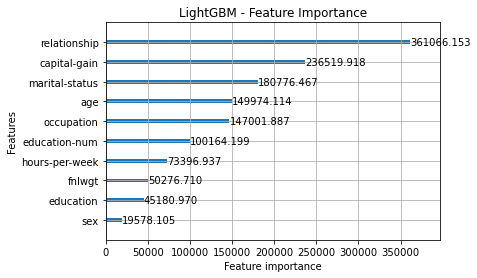

In [39]:
fig, ax = plt.subplots()
lgb.plot_importance(model, max_num_features=10, ax=ax,importance_type='gain')
plt.title("LightGBM - Feature Importance");

In [41]:
y_pred=model.predict(X_test)

# Finding best model threshold

In [42]:

y_prob=model.predict(X_test)
for i in range(4,7,1):
    th=i/10
    print("Testing for threshold ",th)
    #rounding the values
    y_pred=np.where(y_prob>th,1,0)
    #converting from float to integer
    y_pred=y_pred.astype(int)

    print("AUC",metrics.roc_auc_score(y_test, y_pred))
    print("Precision",metrics.precision_score(y_test, y_pred))
    print("Recall",metrics.recall_score(y_test, y_pred))
    print("F1",metrics.f1_score(y_test, y_pred))
    print("Accuracy Score", metrics.accuracy_score(y_test, y_pred))
    print('*************')

Testing for threshold  0.4
AUC 0.8304321047915433
Precision 0.5340017436791631
Recall 0.8935083880379285
F1 0.6684856753069578
Accuracy Score 0.7963459604425075
*************
Testing for threshold  0.5
AUC 0.8284453577089231
Precision 0.5745526838966203
Recall 0.8431801604668125
F1 0.6834170854271356
Accuracy Score 0.8204827355011733
*************
Testing for threshold  0.6
AUC 0.823758660072749
Precision 0.6273255813953489
Recall 0.7870167760758571
F1 0.6981559365901003
Accuracy Score 0.8436138115990613
*************


Threshold of 0.6 is giving the best balance between precision and recall

# Creating final model on entire data

In [43]:
#Fitting on best parameters
params={'boosting_type': 'gbdt',
 'feature_fraction':.6,
 'is_unbalance': True,
 'learning_rate': 0.01,
 'max_depth': 10,
 'metric': 'auc',
 'num_leaves': 30,
 'objective': 'binary',
 'verbosity': -1,
 'early_stopping_rounds':50,
    
}
final_train=lgb.Dataset(X, label=Y)
#train the model on best params
final_model=lgb.train(params,final_train,valid_sets=[final_train],verbose_eval=50,num_boost_round=1000)

F:\Anaconda_new\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.914927
[100]	training's auc: 0.916985
[150]	training's auc: 0.918781
[200]	training's auc: 0.920952
[250]	training's auc: 0.922529
[300]	training's auc: 0.924609
[350]	training's auc: 0.926197
[400]	training's auc: 0.927674
[450]	training's auc: 0.929107
[500]	training's auc: 0.930456
[550]	training's auc: 0.93172
[600]	training's auc: 0.932788
[650]	training's auc: 0.933863
[700]	training's auc: 0.93485
[750]	training's auc: 0.935753
[800]	training's auc: 0.936602
[850]	training's auc: 0.937399
[900]	training's auc: 0.938174
[950]	training's auc: 0.93896
[1000]	training's auc: 0.939689
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.939689


# Scoring on given test data

In [44]:
test=pd.read_csv('adult.test',header=None)

test.columns=['age','workclass','fnlwgt','education','education-num',
              'marital-status','occupation','relationship','race','sex',
            'capital-gain', 'capital-loss','hours-per-week','native-country','class']

In [45]:
test.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


# Applying pre-processing on test data

In [46]:
def pre_process(df):
    for c in df.select_dtypes('object').columns.to_list():
        df[c]=df[c].apply(lambda x:x.strip())
    df=df.replace('?', 'other')
    for c in data.select_dtypes('object').columns.to_list():
        df[c]=df[c].apply(lambda x: combine_categories(c,x))
    df['salary>50k']=np.where(df['class']=='>50K.',1,0)
    for c in categorical_feature:
        df[c]=df[c].astype('category')
    return df
test=pre_process(test)
test.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class,salary>50k
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.,1
4,18,other,103497,Some-college,10,Never-married,other,Own-child,White,Female,0,0,30,United-States,<=50K.,0


In [47]:
test_input=test.drop(['class','salary>50k'],axis=1)
test_output=test['salary>50k']

# Checking model performance on test data

In [49]:
# using best threshold of 0.6
model_output_prob=final_model.predict(test_input)
model_output=np.where(model_output_prob>0.6,1,0)
#converting from float to integer
model_output=model_output.astype(int)

print("AUC",metrics.roc_auc_score(test_output, model_output))
print("Precision",metrics.precision_score(test_output, model_output))
print("Recall",metrics.recall_score(test_output, model_output))
print("F1",metrics.f1_score(test_output, model_output))
print("Accuracy Score", metrics.accuracy_score(test_output, model_output))

AUC 0.8251327809445308
Precision 0.64168966249204
Recall 0.7860114404576183
F1 0.706556035993923
Accuracy Score 0.845771144278607


Confusion Matrix

In [50]:
metrics.confusion_matrix(test_output, model_output)

array([[10747,  1688],
       [  823,  3023]], dtype=int64)

## ************************************* End of Assignment *************************************